In [1]:
import logging
L = logging.getLogger(__name__)
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from omegaconf import OmegaConf
import pandas as pd
import seaborn as sns
import scipy.stats as st
import torch
from tqdm.auto import tqdm

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
!pwd
from berp import trainer

/net/vast-storage.ib.cluster/scratch/vast/cpl/jgauthie/scratch/bayesian-erp


In [2]:
workflow = "heilbron2022"
model = "EleutherAI/gpt-neo-2.7B/n10000"

base_model_paradigm = "cannon_wide"
base_model_name = "trf-cannon_3quantiles"
full_model_paradigm = "cannon_wide"
full_model_name = "trf-berp-cannon_3quantiles"

#####

output_test_scores = "evaluate_cannon.csv"
output_test_improvement_scores = "evaluate_cannon_improvement.csv"

#####

model_dirs = [f"workflow/{workflow}/results{'_' + paradigm if paradigm is not None else ''}/{model}/{run_name}"
              for paradigm, run_name in [(base_model_paradigm, base_model_name), (full_model_paradigm, full_model_name)]]

device = "cpu"

In [3]:
base_model = (base_model_paradigm, base_model_name)
full_model = (full_model_paradigm, full_model_name)
all_models = [base_model, full_model]
for d in model_dirs:
    assert Path(d).exists(), d

NameError: name 'Path' is not defined

## Load pipelines

In [6]:
trainers = trainer.load_trainers_from_checkpoints(model_dirs, device=device)

  0%|          | 0/2 [00:00<?, ?model/s]



===== workflow/heilbron2022/results_cannon_wide/EleutherAI/gpt-neo-2.7B/n10000/trf-cannon_3quantiles
confusion: tensor of type torch.float64, shape torch.Size([40, 40])
encoder: "TemporalReceptiveField(alpha=82468.40682196281, fit_intercept=True,\n  \
  \                     name='baf59f60a976403db080a7fc4a154857',\n               \
  \        optim=AdamSolver(n_batches=50,\n                                      \
  \  name='baf59f60a976403db080a7fc4a154857',\n                                  \
  \      random_state=RandomState(MT19937) at 0x14D989024040),\n                 \
  \      sfreq=128.0, tmax=0.75, tmin=0.0)"
encoder__alpha: 82468.40682196281
encoder__fit_intercept: true
encoder__init_scale: 0.1
encoder__n_outputs: null
encoder__name: baf59f60a976403db080a7fc4a154857
encoder__optim: "AdamSolver(n_batches=50, name='baf59f60a976403db080a7fc4a154857',\n\
  \           random_state=RandomState(MT19937) at 0x14D989024040)"
encoder__optim__batch_size: 512
encoder__optim__early_s

## Prepare result containers

In [7]:
# Backwards-infer subject and run from dataset names
test_subjects, test_runs = [], []
encoder_key_re = trainers[0].model.encoder_key_re
for subdataset in trainers[0].data_test.datasets:
    _, subject, run = encoder_key_re.split(subdataset.name)
    test_subjects.append(subject)
    test_runs.append(run.lstrip("/"))

In [8]:
# TODO allow different sensors within and across pipelines
all_sensors = set(tuple(encoder.output_names)
    for trainer in trainers
    for encoder in trainer.model.encoders_.values())
assert len(all_sensors) == 1

In [9]:
ordered_sensors = next(iter(trainers[0].model.encoders_.values())).output_names

In [10]:
test_scores = np.zeros((len(trainers), len(test_runs), len(ordered_sensors))) * np.nan

## Estimate test score

In [11]:
for j, trainer in enumerate(tqdm(trainers, unit="model")):
    test_scores[j] = trainer.score()

  0%|          | 0/2 [00:00<?, ?model/s]

/net/vast-storage.ib.cluster/scratch/vast/cpl/jgauthie/scratch/bayesian-erp/berp/models/trf_em.py:1109: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484809662/work/aten/src/ATen/native/BucketizationUtils.h:33.)
  torch.bucketize(dataset.p_candidates[:, 0], self.recognition_quantile_edges_),


In [12]:
test_scores_df = []
for i_model_run, i_run, i_sensor in np.ndindex(*test_scores.shape):
    test_scores_df.append((
        all_models[i_model_run],
        test_subjects[i_run],
        test_runs[i_run],
        ordered_sensors[i_sensor],
        test_scores[i_model_run, i_run, i_sensor]))
    
test_scores_df = pd.DataFrame(test_scores_df, columns=["model_run", "subject", "run", "sensor", "score"]).groupby(["model_run", "subject", "run", "sensor"]).mean()
test_scores_df.to_csv(output_test_scores)
test_scores_df

score
model_run                                 subject run                    sensor          
(cannon_wide, trf-berp-cannon_3quantiles) 1       run1/slice:17214:22949 A19    -0.013178
                                                                         A7     -0.014504
                                                                         B22     0.081818
                                                                         B4      0.023251
                                                                         C10     0.092690
...                                                                                   ...
(cannon_wide, trf-cannon_3quantiles)      9       run9/slice:16884:22511 B4      0.019896
                                                                         C10     0.073417
                                                                         C22     0.105086
                                                                         C32     0.066872
                                                                         D19     0.054255

[5776 rows x 1 columns]

### Compare means

In [13]:
test_scores.mean(axis=-1).mean(axis=-1)

array([0.05016503, 0.05061419])

In [14]:
(test_scores[1] - test_scores[0]).mean()

0.0004491538745614864

### Paired subjects t-test

In [17]:
# Do a paired t-test mirroring Heilbron comparison
tdf = test_scores_df.groupby(["model_run", "subject", "run"]).score.mean().groupby(["model_run", "subject"]).mean()
diff_df = tdf.loc[all_models[1]] - tdf.loc[all_models[0]]
diff_df.to_csv(output_test_improvement_scores)
st.ttest_1samp(diff_df, popmean=0)

Ttest_1sampResult(statistic=1.8573721813769712, pvalue=0.07969717761725255)

<AxesSubplot:xlabel='model_run', ylabel='score'>

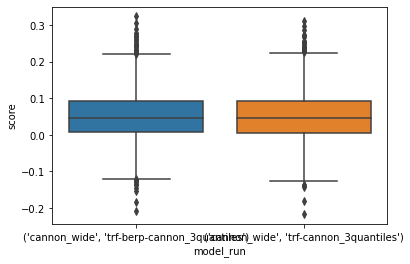

In [30]:
sns.boxplot(data=test_scores_df.reset_index(), x="model_run", y="score")

<AxesSubplot:xlabel='subject', ylabel='score'>

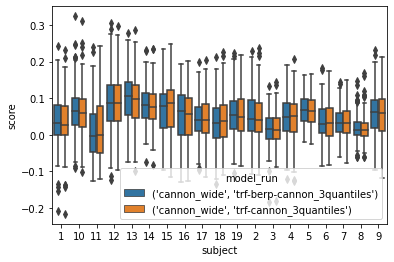

In [31]:
sns.boxplot(data=test_scores_df.reset_index(), x="subject", y="score", hue="model_run")

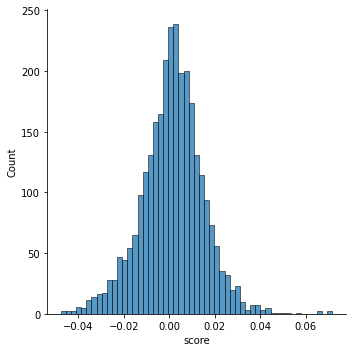

In [32]:
model_diffs = test_scores_df.loc[all_models[1]] - test_scores_df.loc[all_models[0]]
model_diffs = model_diffs.reset_index()
sns.displot(data=model_diffs, x="score")

Text(0, 0.5, 'Difference score')

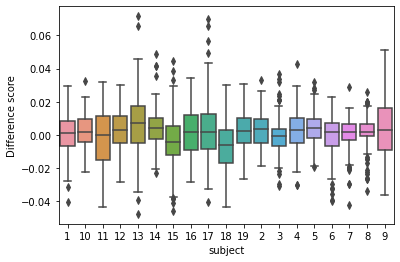

In [33]:
sns.boxplot(data=model_diffs, x="subject", y="score")
plt.ylabel("Difference score")

### Bootstrap estimate of difference within-subject

95% bootstrap CI: [0.00018565 0.00282659]


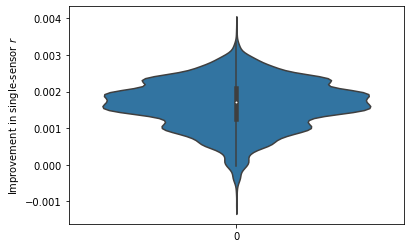

In [34]:
model_diffs_bootstrap = sns.algorithms.bootstrap(model_diffs.score, func="median", units=model_diffs.subject)
sns.violinplot(model_diffs_bootstrap)
plt.ylabel("Improvement in single-sensor $r$")
print("95% bootstrap CI:",
      np.quantile(model_diffs_bootstrap, (0.025, 0.975)))